In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.stats.multitest as smm
from scipy import stats
import seaborn as sns

from Bio import Seq

pd.options.mode.chained_assignment = None

#makes viewing pandas tables better
pd.set_option('display.max_colwidth', 0)

Change the following parameters to your output directory (where you want output files to be written), your metafile, and TNseq output. 

If these files aren't in the same directory as this notebook, you need use the full path. For example, the full path of 'barseq_output' would be '/usr2/people/clairedubin/barseq/barseq_output'

Also change the control and experimental temperatures if needed.

In [2]:
#where the BarSeq FASTQs are
FASTQ_directory = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads'


## Barseq metafile

You'll need to create your own metafile - easiest way is edit in Excel. A sample metafile is located at: /usr2/people/clairedubin/barseq/Kluyv_BarSeq_metadata.txt

    Fastq: path to barseq FASTQ for each competition
    SampleName: unique name for each competition, MUST include ctrl_temp or exp_temp as specified above
    DualIndex: index from sequencing (in read name lines of FASTQ and the sequencing info file that Adam sends)
    
    UsePrecounted: True if you've already run the Barseq counting script on a competition, False otherwise
    
    poolfile: path to Tnseq output file, should be the same for each competition
    output_dir: path to output directory
    minRandom: number of bases between start of read and DualIndex, usually in sequence of 1,2,3,4,1,2,3,4 for each sample
    maxRandom: same as minRandom
    
    BeforeBarcode: sequence preceding all barcodes
    AfterBarcode: sequence following all barcodes
    BarcodeLengths: lengths of barcodes to search for, with expected length of barcode first

    

In [3]:
!ls {FASTQ_directory}/*fastq

/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A1_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A2_S2_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B1_S3_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B2_S4_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50A1_S5_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq

In [4]:
#format: sample_name, fastq_path, dual_index, offset
#add or delete more lines as needed

sample_info = [('37_A1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A1_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('37_A2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A2_S2_L001_R1_001.fastq', 'TTAGGC', '3'),
               ('37_B1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B1_S3_L001_R1_001.fastq', 'CGATGT', '2'),
               ('37_B2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B2_S4_L001_R1_001.fastq', 'TGACCA', '4'),
               ('50_A1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50A1_S5_L001_R1_001.fastq', 'ACAGTG', '1'),
               ('50_A2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50A2_S6_L001_R1_001.fastq', 'CAGATC', '3'),
               ('50_B1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50B1_S7_L001_R1_001.fastq', 'GCCAAT', '2'),
               ('50_B2', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50B2_S8_L001_R1_001.fastq', 'ACTTGA', '4'),
                ]

In [5]:
!head /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A1_S1_L001_R1_001.fastq

@VH00771:102:AAGC27TM5:1:1101:63373:1038 1:N:0:ATTACG
CNCACTAGTCGACCTGCAGCGTACGGTGCAACAAACAGTATGCGCAGAGACCTCGTGGACATCAGATCGGAAGAGCACATGTTTGGATTCTAGTCACATTACGATTTGGGGGGGGGGGGGGGGGGGGGGGGG
+
I#IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII-II9IIIIIIIIII-III99I-9--9I-9----999I99-IIIII
@VH00771:102:AAGC27TM5:1:1101:63449:1038 1:N:0:ATTACG
GNCACTAGTCGACCTGCAGCGTACGTAGGCAACCACACGAGCCGTAGAGACCTCGTGGACATCAGATCGGAAGAGCACATGTTTGGACTCTAGTCATATTACGATTTGGGGGGGGGGGGGGGGGGGGGGGGG
+
I#IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII-IIIIIIIIIIIIIIIIIIIIIIII9II9IIIII-IIII9II99-9I99-99------9--II-9I9III
@VH00771:102:AAGC27TM5:1:1101:63525:1038 1:N:0:ATTACG
TNCACTAGTCGACCTGCAGCGTACGATACGAAATTATGAGCTGTCAGAGACCTCGTGGACATCAGATCGGAAGAGCACATGTTTGGACTCTAGTCACATTACGATTTGGGGGGGGGGGGGGGGGGGGGGGGG


### To convert the annotated file to csv and not to be separated by tab (execute the next three lines only if necessary)

In [6]:
poolfile1 = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated.csv'
df=pd.read_csv(poolfile1,sep='\t')

In [7]:
df.to_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv',index=None)

In [8]:
df=pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv')

In [9]:
#these variables should be the same for each replicate

metafile_name = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_10_28_2024.txt'
logfile_name = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_10_28_2024.log'
poolfile = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv'
output_dir = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024'
before_barcode = 'GTCGACCTGCAGCGTACG' #bottom strand sequence was used
#before_barcode = 'GATGTCCACGAGGTCTCT' #what was there before 
after_barcode =  'AGAGACCTCGTGGACATC' #bottom strand sequence was used
#after_barcode = 'CGTACGCTGCAGGTCGAC'  #what was there before 
barcode_lengths = '20,19,18,21'

In [10]:
#if there are any samples where you already counted barcodes, add the sample names here
precounted_samples = []

In [11]:
metafile_columns = ['FileIndex','SampleName', 'Fastq', 'DualIndex', 'Poolfile', 'OutputDir', 'minRandom', 'maxRandom',
                   'BeforeBarcode', 'AfterBarcode', 'BarcodeLengths', 'UsePrecounted']

with open(metafile_name, 'w') as f:
    
    #write column names
    f.write('\t'.join(metafile_columns)+'\n')
    
    #write a line for each pool
    for sample_name, fastq, dual_index, offset in sample_info:
        
        #DUAL INDECES ARE BACKWARDS FROM WHAT THE FLOWCELL OUTPUT SAYS
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index[::-1], poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'False'])
        f.write(to_write+'\n')
        
    for precounted_sample_name in precounted_samples:
        
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index, poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'True'])




### Check metafile

In [12]:
pd.read_csv(metafile_name, sep='\t')

,FileIndex,SampleName,Fastq,DualIndex,Poolfile,OutputDir,minRandom,maxRandom,BeforeBarcode,AfterBarcode,BarcodeLengths,UsePrecounted
0,37_A1,37_A1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A1_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
1,37_A2,37_A2,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37A2_S2_L001_R1_001.fastq,CGGATT,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024,3,3,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
2,37_B1,37_B1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B1_S3_L001_R1_001.fastq,TGTAGC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024,2,2,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
3,37_B2,37_B2,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/37B2_S4_L001_R1_001.fastq,ACCAGT,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024,4,4,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
4,50_A1,50_A1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50A1_S5_L001_R1_001.fastq,GTGACA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_13k_mutants_mapping_output_all_fastqs_available/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
5,50_A2,50_A2,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/Barseq_37•C_vs_50•C_500_million_reads/50A2_S6_L001_R1_001.fastq,CTAGAC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequ

## Barseq counting

Might take a few hours!

In [13]:
!python3 /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/RBseq_Count_BarCodes_v2.py -m {metafile_name} -l {logfile_name}

2024-10-29 09:40:57 RBseq_Count_BarCodes.py
2024-10-29 09:40:57 Version: 1.1.4
2024-10-29 09:40:57 Release Date: July 16, 2020
2024-10-29 09:40:57 Options passed:  metafile:/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_10_28_2024.txt  logFile:/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_10_28_2024.log  minQual:10  matchBefore:6  matchAfter:6  quietMode:False 
2024-10-29 09:40:57 Logging status updates in /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/BarSeq_metafile_13k_mutants_37•C_vs_50•C_10_28_2024.log
2024-10-29 09:40:57 Loading TnSeq library metadata from /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_ava

2024-10-29 10:17:09     42029828 reads processed.
2024-10-29 10:17:09     39507992 reads with compliant barcodes.
2024-10-29 10:17:09     2521836 reads without recognizable, compliant barcodes. Of those:
2024-10-29 10:17:09       1397496 reads without expected Dual Index.
2024-10-29 10:17:09       915194 reads without expected sequence before the barcode region.
2024-10-29 10:17:09       209146 reads without expeced sequence after the barcode region.
2024-10-29 10:17:09       0 reads with noncompliant barcdes. (Contains Ns, etc).
2024-10-29 10:17:09       0 reads with quality scores less than 10
2024-10-29 10:17:09   Saving barcode counts to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/countsFiles/37_B2.counts
2024-10-29 10:17:11   Total barcodes seen (incudes sequencing errors): 522282
2024-10-29 10:17:11   Matching barcodes 

2024-10-29 10:45:21     38221312 reads processed.
2024-10-29 10:45:21     36020255 reads with compliant barcodes.
2024-10-29 10:45:21     2201057 reads without recognizable, compliant barcodes. Of those:
2024-10-29 10:45:21       1211704 reads without expected Dual Index.
2024-10-29 10:45:21       810064 reads without expected sequence before the barcode region.
2024-10-29 10:45:21       179289 reads without expeced sequence after the barcode region.
2024-10-29 10:45:21       0 reads with noncompliant barcdes. (Contains Ns, etc).
2024-10-29 10:45:21       0 reads with quality scores less than 10
2024-10-29 10:45:21   Saving barcode counts to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/countsFiles/50_B2.counts
2024-10-29 10:45:22   Total barcodes seen (incudes sequencing errors): 552661
2024-10-29 10:45:22   Matching barcodes 

# Making Scatter Plots

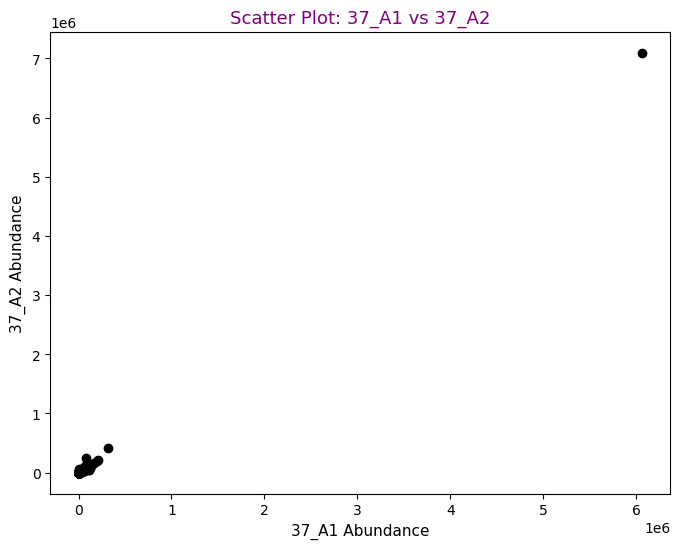

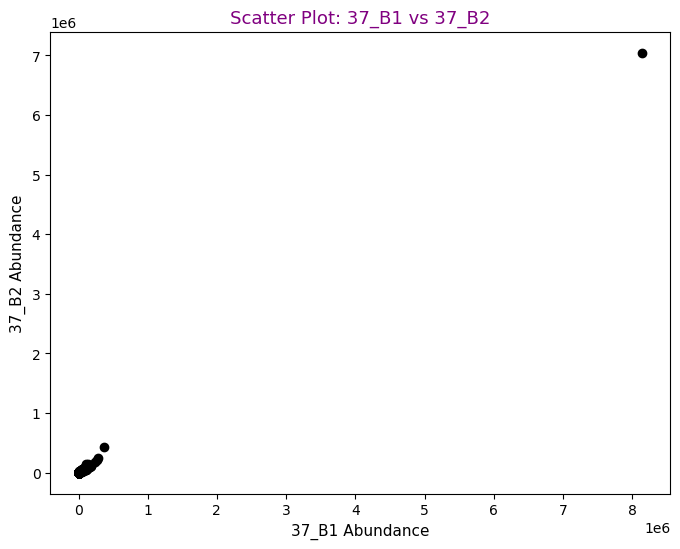

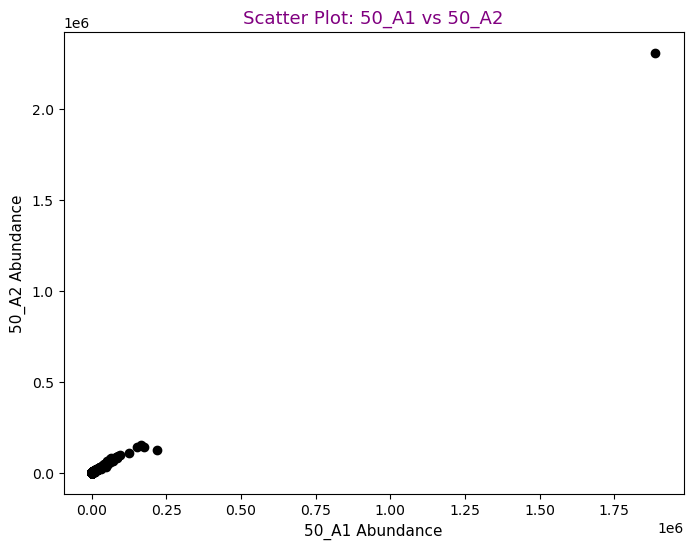

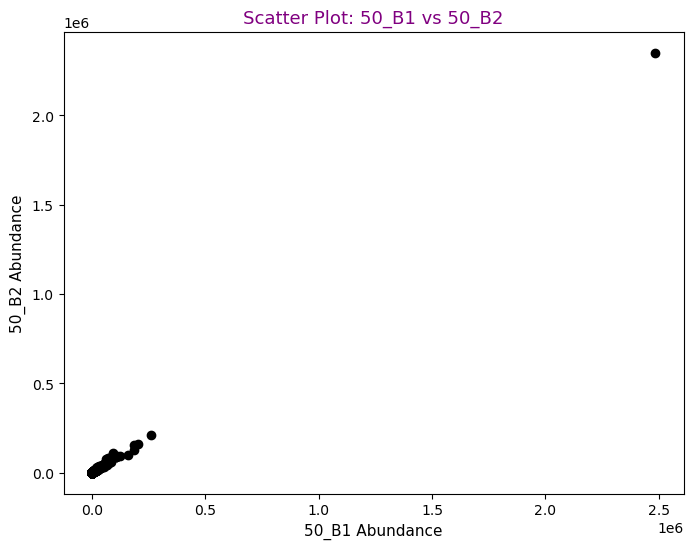

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount.txt', sep='\t')  # Update with your file path

# Define the pairs of columns for scatter plots
column_pairs = [
    ('37_A1', '37_A2'),
    ('37_B1', '37_B2'),
    ('50_A1', '50_A2'),
    ('50_B1', '50_B2')
]

# Plotting each pair of columns
for x_column, y_column in column_pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    plt.show()


### Ajusting the axis of the scatter plots

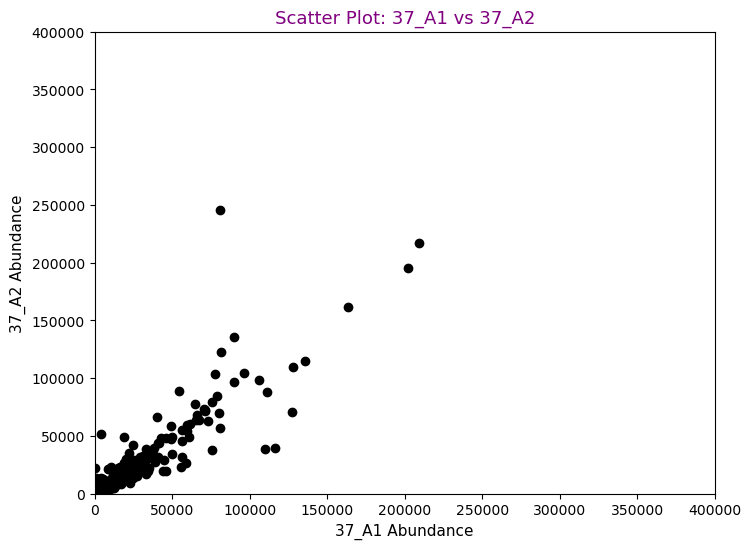

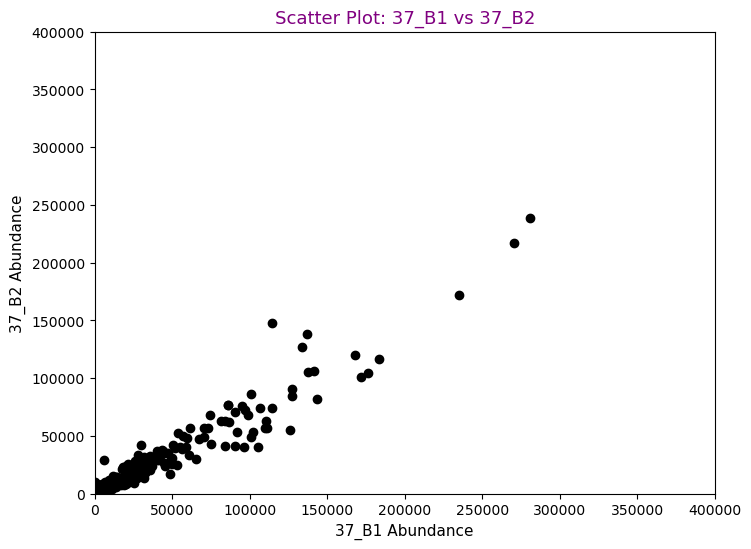

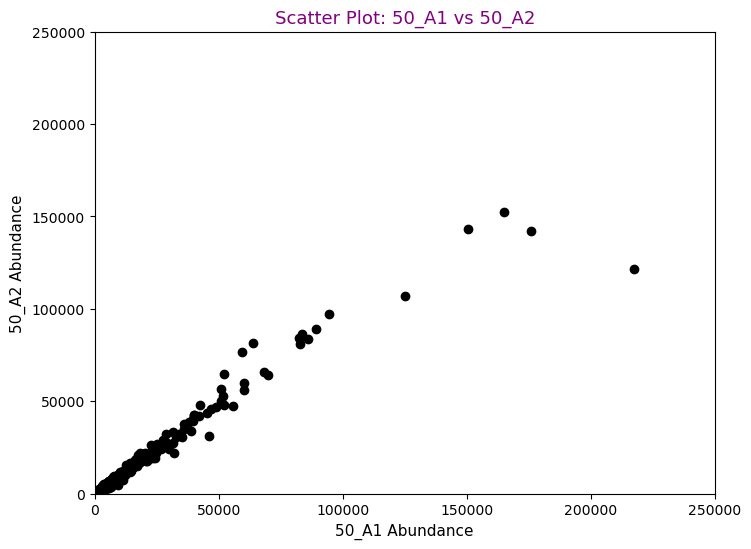

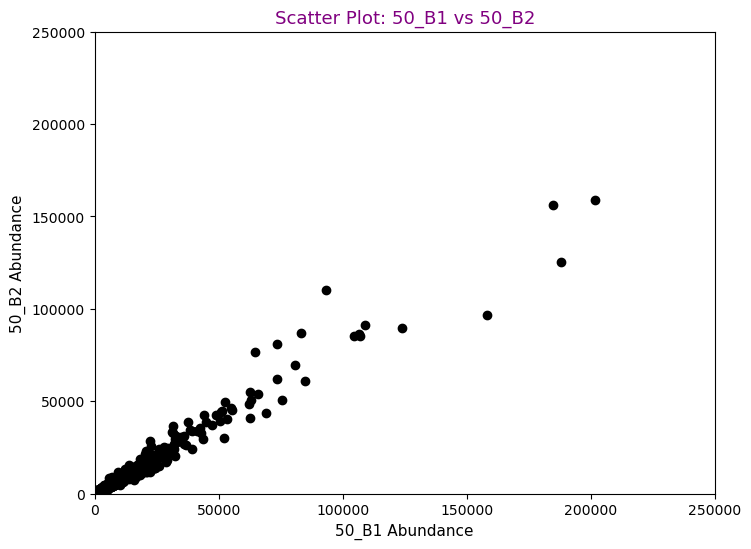

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount.txt', sep='\t')  # Update with your file path

# Define the pairs of columns and their axis limits for scatter plots
column_pairs = [
    ('37_A1', '37_A2'),
    ('37_B1', '37_B2'),
    ('50_A1', '50_A2'),
    ('50_B1', '50_B2')
]

# Set custom axis limits for each pair (adjust as needed)
axis_limits = {
    '37_A1_37_A2': {'xlim': (0, 400000), 'ylim': (0, 400000)},
    '37_B1_37_B2': {'xlim': (0, 400000), 'ylim': (0, 400000)},
    '50_A1_50_A2': {'xlim': (0, 250000), 'ylim': (0, 250000)},
    '50_B1_50_B2': {'xlim': (0, 250000), 'ylim': (0, 250000)}
}

# Plotting each pair of columns with custom axis limits
for x_column, y_column in column_pairs:
    key = f'{x_column}_{y_column}'
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    
    # Apply axis limits if available
    if key in axis_limits:
        plt.xlim(axis_limits[key]['xlim'])
        plt.ylim(axis_limits[key]['ylim'])

    plt.show()


## to normalize the Barseq pool count file based on the number of reads obtained

### this is the normalization that worked with the right result

In [19]:
import pandas as pd

# Load the count file into a DataFrame
count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount.txt'
df = pd.read_csv(count_file_path, sep='\t')

# Calculate the total counts for each replicate
df['Total_Count_37_A1'] = df['37_A1'].sum()
df['Total_Count_37_A2'] = df['37_A2'].sum()
df['Total_Count_37_B1'] = df['37_B1'].sum()
df['Total_Count_37_B2'] = df['37_B2'].sum()
df['Total_Count_50_A1'] = df['50_A1'].sum()
df['Total_Count_50_A2'] = df['50_A2'].sum()
df['Total_Count_50_B1'] = df['50_B1'].sum()
df['Total_Count_50_B2'] = df['50_B2'].sum()



# Normalize counts for each replicate by dividing by its own Total_Count
df['normalized_37_A1'] = df['37_A1'] / df['Total_Count_37_A1']
df['normalized_37_A2'] = df['37_A2'] / df['Total_Count_37_A2']
df['normalized_37_B1'] = df['37_B1'] / df['Total_Count_37_B1']
df['normalized_37_B2'] = df['37_B2'] / df['Total_Count_37_B2']
df['normalized_50_A1'] = df['50_A1'] / df['Total_Count_50_A1']
df['normalized_50_A2'] = df['50_A2'] / df['Total_Count_50_A2']
df['normalized_50_B1'] = df['50_B1'] / df['Total_Count_50_B1']
df['normalized_50_B2'] = df['50_B2'] / df['Total_Count_50_B2']

# Save the normalized count file
normalized_count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.csv'
df.to_csv(normalized_count_file_path, index=False)


##### To make the fitness abundance agaian using the normalized values

In [32]:
import pandas as pd

# Load the CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.csv'
df = pd.read_csv(csv_file_path)

# Save the DataFrame to a text file (txt)
txt_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.txt'
df.to_csv(txt_file_path, sep='\t', index=False)


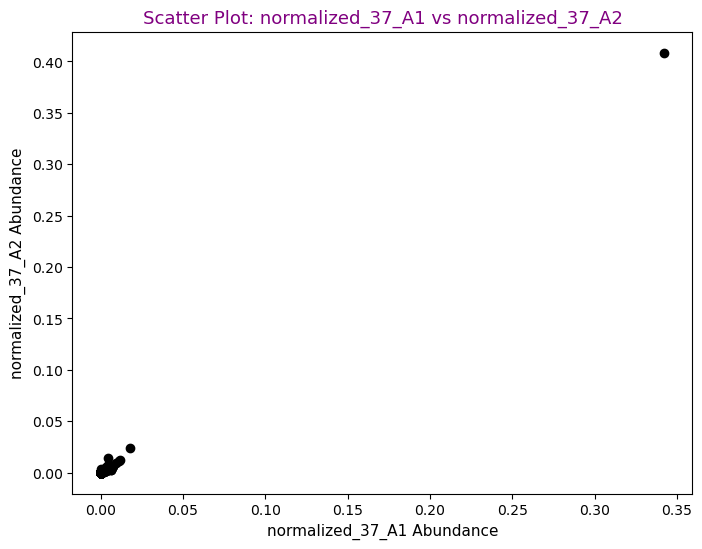

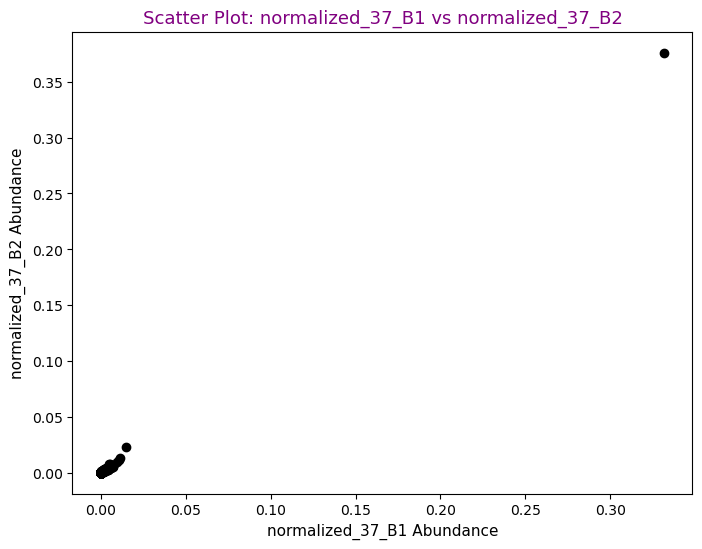

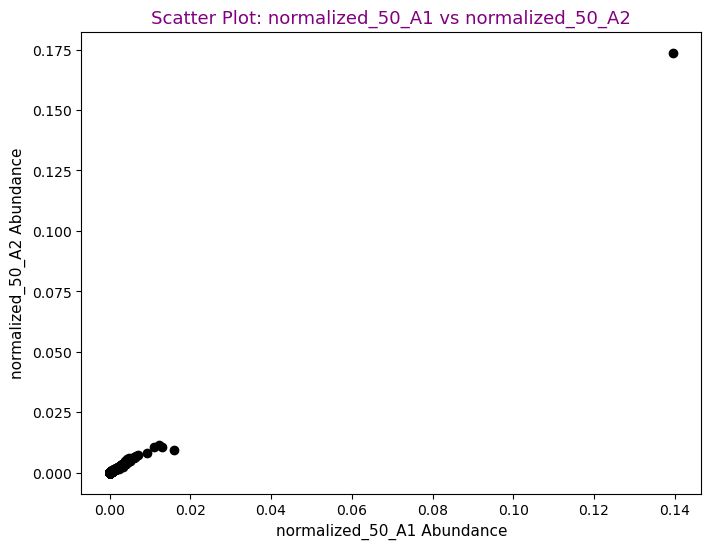

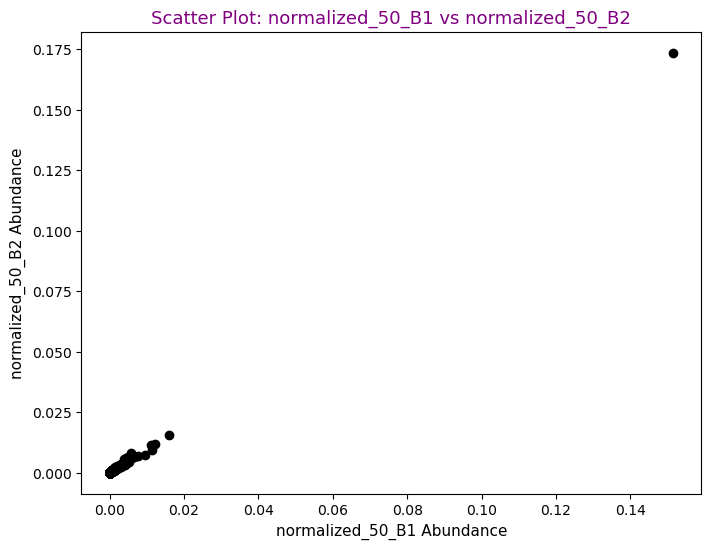

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.txt', sep='\t')

# Define the pairs of columns for scatter plots
column_pairs = [
    ('normalized_37_A1', 'normalized_37_A2'),
    ('normalized_37_B1', 'normalized_37_B2'),
    ('normalized_50_A1', 'normalized_50_A2'),
    ('normalized_50_B1', 'normalized_50_B2')
]

# Plotting each pair of columns
for x_column, y_column in column_pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    plt.show()


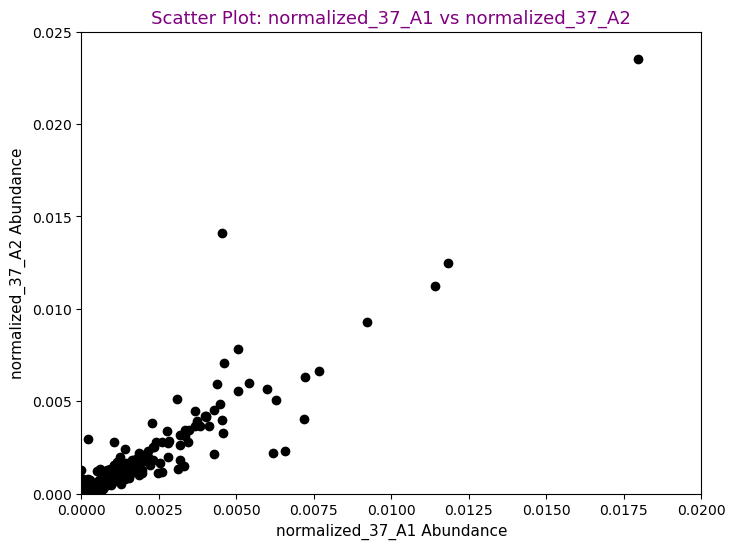

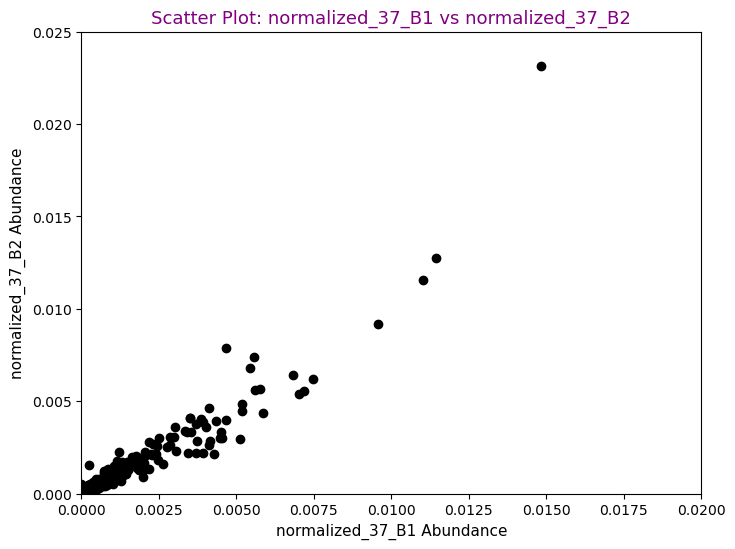

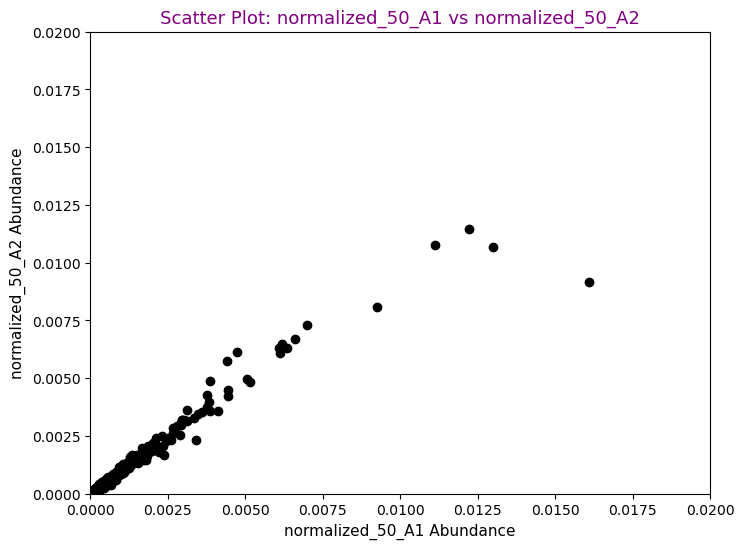

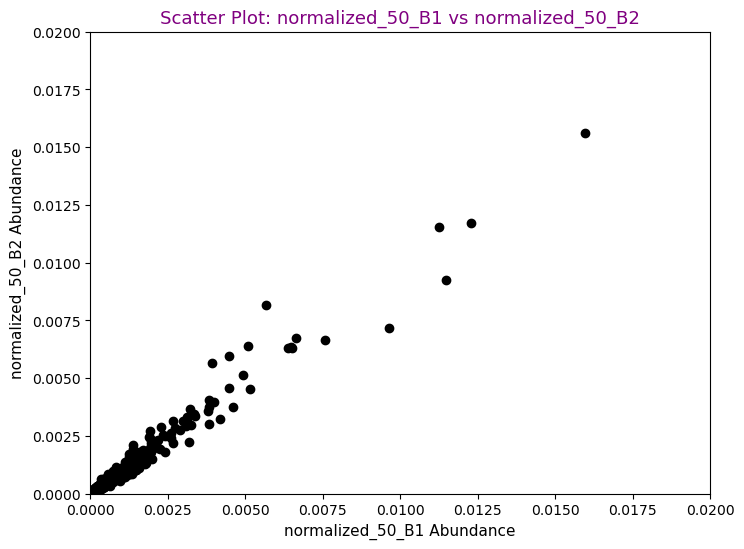

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.txt', sep='\t')

# Define the pairs of columns and their axis limits for scatter plots
column_pairs = [
    ('normalized_37_A1', 'normalized_37_A2'),
    ('normalized_37_B1', 'normalized_37_B2'),
    ('normalized_50_A1', 'normalized_50_A2'),
    ('normalized_50_B1', 'normalized_50_B2')
]

# Set custom axis limits for each pair (adjust as needed)
axis_limits = {
    'normalized_37_A1_normalized_37_A2': {'xlim': (0, 0.02), 'ylim': (0, 0.025)},
    'normalized_37_B1_normalized_37_B2': {'xlim': (0, 0.02), 'ylim': (0, 0.025)},
    'normalized_50_A1_normalized_50_A2': {'xlim': (0, 0.02), 'ylim': (0, 0.02)},
    'normalized_50_B1_normalized_50_B2': {'xlim': (0, 0.02), 'ylim': (0, 0.02)}
}

# Plotting each pair of columns with custom axis limits
for x_column, y_column in column_pairs:
    key = f'{x_column}_{y_column}'
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_column], df[y_column], color='black')
    plt.xlabel(f'{x_column} Abundance', fontsize=11)
    plt.ylabel(f'{y_column} Abundance', fontsize=11)
    plt.title(f'Scatter Plot: {x_column} vs {y_column}', fontsize=13, color='purple')
    
    # Apply axis limits if available
    if key in axis_limits:
        plt.xlim(axis_limits[key]['xlim'])
        plt.ylim(axis_limits[key]['ylim'])

    plt.show()


# To do statistical t-test

### To handle rows where some values are zero and convert them to NaN before performing the Mann-Whitney U test

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# Load the dataset
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.csv')

# Convert all columns to numeric, coercing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace zeros with NaN
df.replace(0, np.nan, inplace=True)

# Define the data columns for the existing and new conditions
data_37C = df[['normalized_37_A1', 'normalized_37_A2', 'normalized_37_B1', 'normalized_37_B2']]
data_50C = df[['normalized_50_A1', 'normalized_50_A2', 'normalized_50_B1', 'normalized_50_B2']]
            



# List to store p-values for existing conditions
p_values_37_vs_50 = []

# Iterate over rows and perform Mann-Whitney U test for each
for index, row in df.iterrows():
    # Drop NaN values from the datasets
    data_37C_values = row[data_37C.columns].dropna()
    
    

    # Perform the Mann-Whitney U test for 37C vs. 50C
    #data_37C_values = row[data_25C.columns].dropna()
    data_50C_values = row[data_50C.columns].dropna()

    if len(data_37C_values) > 0 and len(data_50C_values) > 0:
        statistic, p_value = mannwhitneyu(data_37C_values, data_50C_values, alternative='two-sided')
        p_values_37_vs_50.append(p_value)
    else:
        p_values_37_vs_50.append(np.nan)

# Add the p-values to the DataFrame

df['MannWhitneyU_p_value_37_vs_50'] = p_values_37_vs_50

# Save the DataFrame with the calculated p-values to a new CSV file
output_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C_output_with_mannwhitneyu_p_values_zero_values_removed_combined.csv'
df.to_csv(output_path, index=False)


In [31]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# Load the dataset
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount_37•C_vs_50•C.csv')

# Convert all columns to numeric, coercing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace zeros with NaN
df.replace(0, np.nan, inplace=True)

# Define the data columns for the existing and new conditions
data_37C = df[['37_A1', '37_A2', '37_B1', '37_B2']]
data_50C = df[['50_A1', '50_A2', '50_B1', '50_B2']]
            



# List to store p-values for existing conditions
p_values_37_vs_50 = []

# Iterate over rows and perform Mann-Whitney U test for each
for index, row in df.iterrows():
    # Drop NaN values from the datasets
    data_37C_values = row[data_37C.columns].dropna()
    
    

    # Perform the Mann-Whitney U test for 37C vs. 50C
    #data_37C_values = row[data_25C.columns].dropna()
    data_50C_values = row[data_50C.columns].dropna()

    if len(data_37C_values) > 0 and len(data_50C_values) > 0:
        statistic, p_value = mannwhitneyu(data_37C_values, data_50C_values, alternative='two-sided')
        p_values_37_vs_50.append(p_value)
    else:
        p_values_37_vs_50.append(np.nan)

# Add the p-values to the DataFrame

df['MannWhitneyU_p_value_37_vs_50'] = p_values_37_vs_50

# Save the DataFrame with the calculated p-values to a new CSV file
output_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/all_fastqs_available/TNSeq_barseq_outputs_using_all_fastqs_combined_13k_mutants_37•C_vs_50•C_10_28_2024/poolCount__raw_37•C_vs_50•C_output_with_mannwhitneyu_p_values_zero_values_removed_combined.csv'
df.to_csv(output_path, index=False)
